# Code description of Time Return trend model<a class="tocSkip">

The aim of this model is to capture long term trends while avoiding common problem of early stop out. This strategy is taken from the book __Trading Evolved__ in chapter 16. This strategy is there described for trading with futures, however the necessary modifications have been done in order to implement the model for trading securities.

To actually implement this model, you need a substantial sum of money, a large number of positions need be open at any given time and you constantly run on a very high margin to equity ratio (in the case of futures).

***

## Content

- Section 0 : the strategy
- Section 1 : libraries
- Section 2 : helper functions and model settings
- Section 3 : main functions (__initialize__, __rebalance__)
- Section 4 : running backtest
- Section 5 : Pyfolio tear sheet

## The strategy

### Model purpose
The time return trend model is one of the simplest trend models to implement. It captures long term trends while avoiding an early stop out.

All too often, classic trend following models suffer from taking their stops too early on short term pullbacks, only to see prices return back to the trend again. While these classic trend models tend to show strong long term performance despite this issue, the time return trend model is not susceptible to the problem at all.

### Investment Universe
The Time Return trend model also requires a significantly diversified portfolio, which usually translates into a significant initial capital requirement.

### Trading Frequency
With this particular model, we only trade once per month. We completely ignore anything that happens during that month. No matter how large the moves, no action is taken during the month.

### Position allocation
The position sizes taken for this model aim to take an equal amount of risk per position. For a given security, the total allocation is given by the following : 

$$ C = \frac{R P}{\sigma}, $$
where:
- $R =$ risk factor
- $P =$ portfolio value (marked to market)
- $\sigma =$ standard deviation of prices changes

__Important__: The value of sigma is based on the prices changes (the difference), and not on the percentage changes (quotient). The amount of days to consider is defined by the variable __vola_window__.

The value $RP$ represents the amount that we want our portfolio to change __at most__ by a single open position on an asset per day. If we divide this amount by $\sigma$ (which represents the average daily move of the asset) we basically obtain the number of shares that we are allowed to buy without surpassing our risk limits.

**Note**: To keep the logic simple here, no regular rebalancing of position sizes is done, nor is any more complex volatility targeting technique employed. Both of these make more sense for institutional portfolio management than for individual accounts.

### Trading Rules

We define two integer variables, which represent two different time windows:
- `short_trend_window`
- `long_trend_window`

On the first trading day of each month, we will check for each asset if the last day's closing price is higher than the price `short_trend_window` days ago and also `long_trend_window` days ago. If both conditions are satisfied we go long on this asset. We proceed symmetrically for a short position.

If none of the conditions above holds, we close our current position on that asset (in case we have a position open), or we simply do not open a new one.

### Zipline implementation
Recall that the usual zipline backtesting implementation requires the definition of 3 functions:
- __initialize__
- __handle_data__
- __analyze__

A variation of this implementation is done when implementing the Time Return strategy. For this, we define the function __rebalance__, where al the trading logic is done.

We then make use of a particular function provided by the zipline API : __schedule_function__. It will help us call the  __rebalance__ function monthly.

## Libraries

In [1]:
'''
Zipline dependencies
'''
import zipline
from zipline.api import symbol, set_commission, set_slippage, \
    schedule_function, date_rules, set_benchmark, \
    time_rules, order_target
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

'''
Pyfolio dependency
'''
import pyfolio as pf

'''
Other dependencies
'''
%matplotlib notebook
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

## General settings

### Model settings

We first define the model settings. These will be used throughout the whole simulation in order to compute several values required to carry the trading strategy.

In [2]:
"""
Model Settings
"""
starting_portfolio = 10000000
risk_factor = 0.001
vola_window = 60
short_trend_window = 125
long_trend_window = 250
benchmark_symbol = 'AAPL'

"""
Commission and Slippage Settings
"""
enable_commission = True
commission_pct = 0.001
enable_slippage = True 
slippage_volume_limit = 0.2
slippage_impact = 0.1

### Helper functions

We now define the helper functions

In [3]:
def update_chart(context,data):
    '''
    This function continuously updates the graph during the backtest
    '''
    
    today = data.current_session.date()
    dynamic_results.loc[today, 'PortfolioValue'] = context.portfolio.portfolio_value
    
    if ax.lines: # Update existing line
        ax.lines[0].set_xdata(dynamic_results.index)
        ax.lines[0].set_ydata(dynamic_results.PortfolioValue)
    else: # Create new line
        ax.semilogy(dynamic_results)
        
    # Update scales min/max
    ax.set_ylim(
        dynamic_results.PortfolioValue.min(),
        dynamic_results.PortfolioValue.max()
    )
    ax.set_xlim(
        dynamic_results.index.min(),
        dynamic_results.index.max()
    )
    
    # Redraw the graph
    fig.canvas.draw()
    
def position_size(portfolio_value, std, pv=1):
    '''
    Computes risk adjusted contract allocation as a function of volatility.
    
    Args : 
        portfolio_value (float) = total portfolio value marked to market
        std (float) = standard deviation of a given asset
        point_value = size of contract (for equities is 1, for futures it depends on the underlying)
    
    Returns : 
        int = number of contracts to buy 
    
    Raises :
        -
    
    Notes :
        The portfolio is marked to market at each call
    '''
    
    target_variation = portfolio_value * risk_factor
    contract_variation = std * pv
    contracts = target_variation / contract_variation
    return int(np.nan_to_num(contracts))

## Main functions

### Initialize

In [4]:
def initialize(context):
    
    """
    Cost Settings
    """
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
        
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, \
                                           price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)      
        
    set_slippage(slippage_model)
    
    """
    Markets to trade
    """ 
    markets = [
        "AAPL"
    ]
    
    # Set benchmark
    set_benchmark(symbol(benchmark_symbol))
    
    # Make a list of all continuations
    context.universe = [ symbol(market) for market in markets ]
    
    # Schedule daily trading 
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_close())
        
    # Schedule monthly chart update
    #schedule_function(update_chart,date_rules.month_start(), time_rules.market_close())

### Rebalance

In [5]:
def rebalance(context, data):
    # Get the history
    hist = data.history(
        context.universe, 
        fields=['close', 'volume'], 
        frequency='1d', 
        bar_count=long_trend_window,
    ) 
    
    # Make a dictionary of open positions
    #open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions} 
    
    # Loop all markets
    for market in context.universe:
        
        # Slice off history for this market
        h = hist.xs(market, 2)
        
        # Calculate volatility
        std = h.close.diff()[-vola_window:].std()
        
        if market in context.portfolio.positions: # Position is already open
            p = context.portfolio.positions[market]
            if p.amount > 0: # Long position
                if h.close[-1] < h.close[-long_trend_window]:
                    # Lost slow trend, close position
                    order_target(market, 0)
                elif h.close[-1] < h.close[-short_trend_window]:
                    # Lost fast trend, close position
                    order_target(market, 0)
            else: # Short position
                if h.close[-1] > h.close[-long_trend_window]:
                    # Lost slow trend, close position
                    order_target(market, 0)
                elif h.close[-1] > h.close[-short_trend_window]:
                    # Lost fast trend, close position
                    order_target(market, 0)
        
        else:   # No position open yet.   
            if (h.close[-1] > h.close[-long_trend_window]) \
                and \
                (h.close[-1] > h.close[-short_trend_window]):
                    # Buy new position
                    contracts_to_trade = position_size(context.portfolio.portfolio_value, std)
                    order_target(market, contracts_to_trade)
                    
            elif (h.close[-1] < h.close[-long_trend_window]) \
                and \
                (h.close[-1] < h.close[-short_trend_window]):
                    # New short position
                    contracts_to_trade = position_size(context.portfolio.portfolio_value, std)
                    order_target(market, contracts_to_trade *-1)

## Running backtest

In [14]:
"""
Prepare for dynamic chart
"""
'''
dynamic_results = pd.DataFrame()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title('Time Return Performance')
plt.xticks(rotation=45)
'''


'''
Selecting dates
'''
start = datetime(2000, 1, 1, 8, 15, 12, 0, pytz.UTC)
end = datetime(2005, 1, 2, 8, 15, 12, 0, pytz.UTC)

starting_portfolio = 100000
risk_factor = 0.01
vola_window = 60
short_trend_window = 25
long_trend_window = 50
benchmark_symbol = 'AAPL'

'''
Running backtest
'''
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    capital_base=starting_portfolio,  
    data_frequency = 'daily', 
    bundle='quandl' )

## Pyfolio tear sheet

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


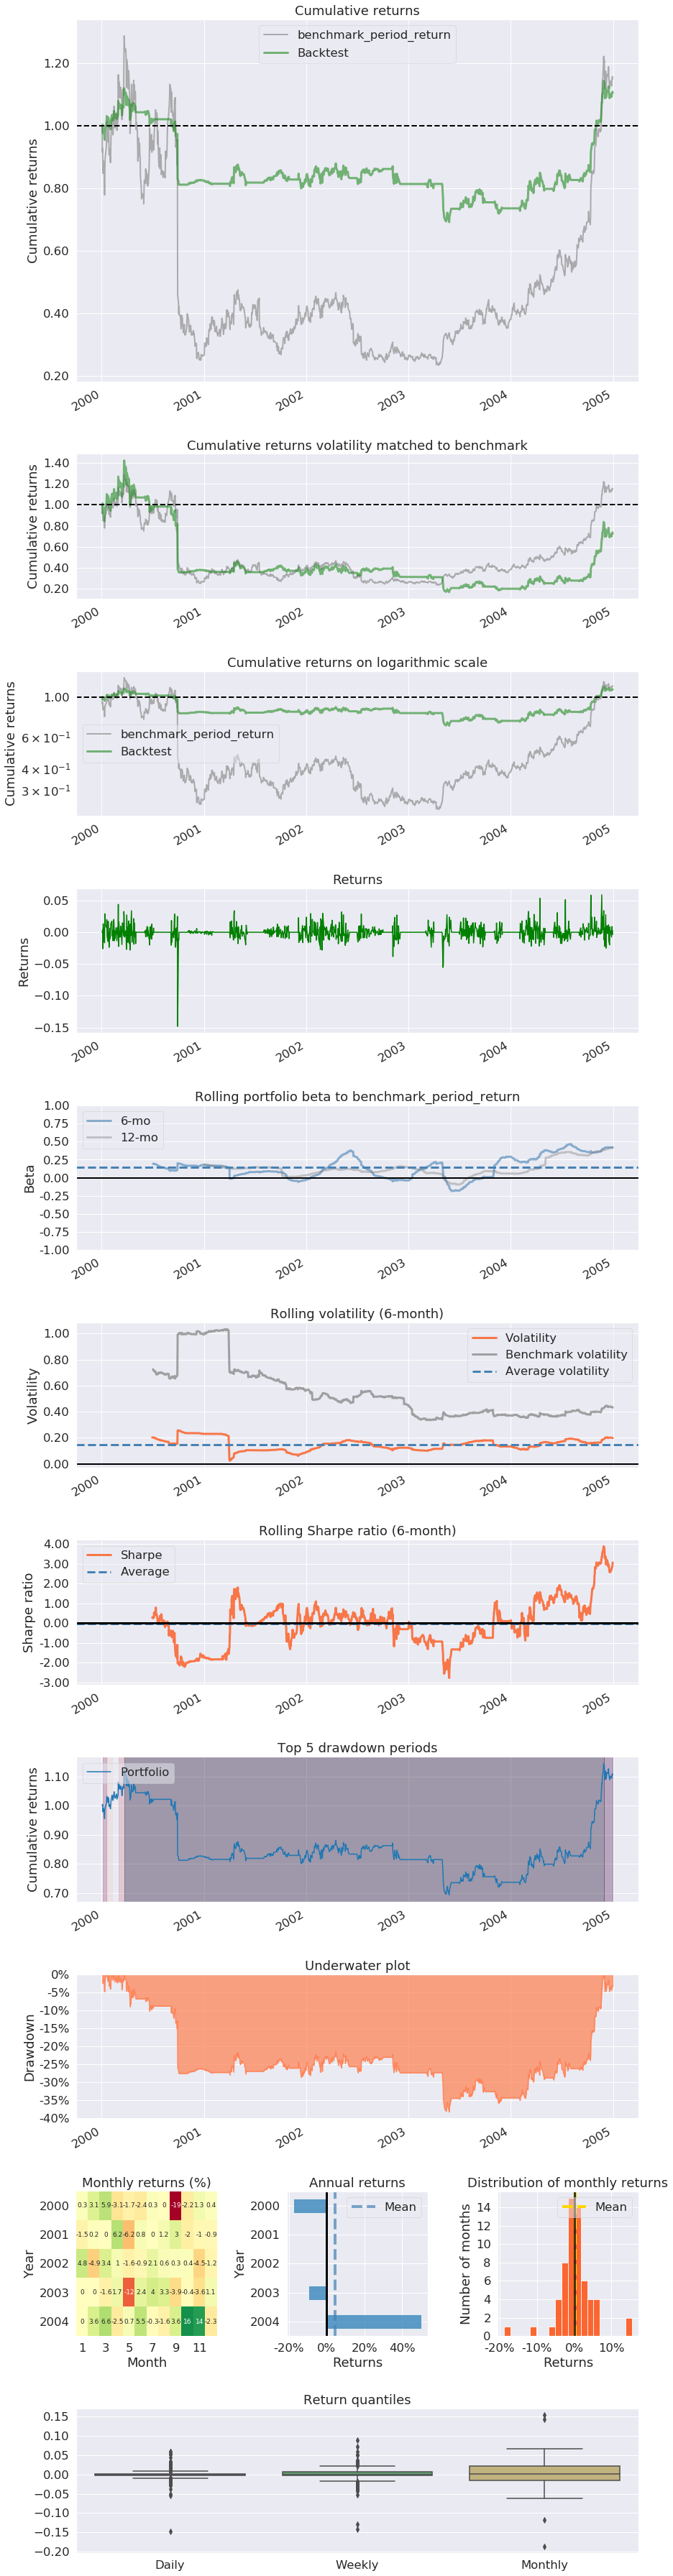

In [15]:
%matplotlib inline
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']
# Convert benchmark returns to daily returns
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1
pf.create_returns_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)